In [62]:
import json
import os
import copy
import random 
import numpy as np
from client import *
import matplotlib.pyplot as plt
import datetime

In [63]:
Team_Key = "VPN75t7UGO44XsrQlo9KuKkg8yRrqgSfyh13GITsQnyvLLyvV5" 
Team_Name = "Platypus_Perry"
max_limit = 10 
min_limit = -10
generations = 10
array_len = 11
population_size = 8
chromosome_size = 11
Mutation_Probability = 0.2         # probabilty that it will mutate
Mutation_Difference_Scale = 1000   # adding noice on mutation to actual value ratio
initial_array = [0.0, -1.45799022e-12, -2.28980078e-13,  4.62010753e-11, -1.75214813e-10, -1.83669770e-15,  8.52944060e-16,  2.29423303e-05, -2.04721003e-06, -1.59792834e-08,  9.98214034e-10]
valid_err_best_weights = 0
train_err_best_weights = 0
best_weights_set = []
fitness_best_weights = 0
population = []
best_valid_err_gen = []
best_train_err_gen = []
best_fit_gen = []

In [64]:
def add_noise(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1    
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(8, 12)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*10)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)
def add_noise_populate(arr):
    for id, val in np.ndenumerate(arr):
        Mutation_Probability = 1      
#         Mutation_Probability = np.random.random()
        Mutation_Difference_Scale = np.random.randint(8, 10)
        chance = np.random.random()
        if chance < Mutation_Probability:
            range_var = val/Mutation_Difference_Scale
            if val == 0:
                range_var = np.mean(arr)/(Mutation_Difference_Scale*10)
            arr[id] = arr[id] + np.random.uniform(-range_var,0)
    return np.clip(arr, min_limit, max_limit)
def populate(arr):
    arra = []
    for i in range(0,population_size):
        arra.append(arr)
    arra = np.array(arra, dtype=np.double)
    arra = add_noise_populate(arra)
    arra[0] = arr
    return arra
def Roulette_Wheel_Selection(arr ,fitness_sum):
    random_nu = random.uniform(0,fitness_sum)
    for id, val in np.ndenumerate(arr):
        if (val > random_nu):
            return id
    return len(arr) - 1

In [65]:
def get_gen(name_file, i , population):
    j = i
    selected_population = []
    crossovered_population = []
    mutated_population = []
    # global population
    global fitness_best_weights
    global valid_err_best_weights
    global train_err_best_weights

    global best_fit_gen
    global best_train_err_gen
    global best_valid_err_gen
    #finding errors
    fitness = []
    train_error = []
    valid_error = []
    for chromosomes in population:
        train_err, valid_err = get_errors(Team_Key, list(chromosomes))
#         train_err = 1*j
#         valid_err = 1*j
        train_error.append(train_err)
        valid_error.append(valid_err)
        fitness.append(-(train_err + valid_err))

    #updating err values
    best_fit_id = np.argmax(fitness)
    if ( (fitness_best_weights == 0) or (fitness[best_fit_id] > fitness_best_weights)):
        fitness_best_weights = fitness[best_fit_id]
        valid_err_best_weights = valid_error[best_fit_id]
        train_err_best_weights = train_error[best_fit_id]
        best_weights_set[:] = population[best_fit_id]
    
    best_fit_gen.append((-1)*fitness[best_fit_id])
    best_valid_err_gen.append(valid_error[best_fit_id])
    best_train_err_gen.append(train_error[best_fit_id])

    scaled_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) #fitness is scaled from 0 to 1
    partial_sum = []
    sum_fitness = np.sum(scaled_fitness)
    part = 0.0
    for val in scaled_fitness:
        part = part + val
        partial_sum.append(part)

    crossover =[]
    for i in range(0, population_size//2):
        # selection
        selected_f = population[Roulette_Wheel_Selection(partial_sum ,sum_fitness)]
        selected_s = population[Roulette_Wheel_Selection(partial_sum ,sum_fitness)]
        selected_population.append(selected_f)
        selected_population.append(selected_s)

        # crossover 
        crossovered_f = np.empty(11)        
        crossovered_s = np.empty(11)
        u = random.random()
        nc = 3
        if (u < 0.5):
            beta = (2 * u)**((nc + 1)**-1)
        else:
            beta = ((2*(1-u))**-1)**((nc + 1)**-1)
            
        parent1 = np.array(selected_f)
        parent2 = np.array(selected_s)
        crossovered_f = 0.5*((1 + beta) * parent1 + (1 - beta) * parent2)
        crossovered_s = 0.5*((1 - beta) * parent1 + (1 + beta) * parent2)
#         crossovered_f = np.copy(selected_f)
#         crossovered_s = np.copy(selected_s)
#         crossover_point = np.random.randint(4,9)
#         crossovered_f[0:crossover_point] = selected_s[0:crossover_point]
#         crossovered_s[0:crossover_point] = selected_f[0:crossover_point]
        crossovered_population.append(crossovered_f)
        crossovered_population.append(crossovered_s)
        crossover.append(crossovered_f)
        crossover.append(crossovered_s)
    
    #mutation
    crossover = np.array(crossover, dtype=np.double)
    population = add_noise(crossover)
    mutated_population = population

    #creating generation files
    file_name = str(name_file) + "/" + "generations_" + str(j+1) + ".txt"
    
    selected_population = np.array(selected_population)
    crossovered_population = np.array(crossovered_population)
    mutated_population = np.array(mutated_population)
    with open(file_name, 'w') as write_file:
        json.dump(selected_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(crossovered_population.tolist(), write_file)
        write_file.write('\n' + '\n')
        json.dump(mutated_population.tolist(), write_file)
    return population


In [66]:
name_file = "generations01211"
if (os.path.isdir(name_file) != 1):
    os.mkdir(name_file)
population = populate(initial_array)
population = np.array(population , dtype=np.double)

for i in range(0,generations):
    population = get_gen(name_file, i , population)
    
print("best values >>>>>>>>",name_file,datetime.datetime.now(),file=open("tt12.txt" , "a"))
print(fitness_best_weights,"\n", valid_err_best_weights,"\n", train_err_best_weights,"\n", best_weights_set,file=open("tt12.txt" , "a"))
print("=================================================================================\n\n\n\n",file=open("tt12.txt" , "a"))


In [18]:
# vvtt = [-7.796984517402969e-10, -1.2759114692062566e-12, -2.0269879488472377e-13, 4.2736379058925144e-11, -1.593031118007237e-10, -1.619038840306331e-15, 7.968442767123957e-16, 2.10026184658057e-05, -1.8134724859015964e-06, -1.4393999162387242e-08, 8.689798005351976e-10]
# vvtt = [-6.434083109283897e-11, -1.3669359761012536e-12, -2.1590401643672617e-13, 4.427649708786989e-11, -1.6420867741237895e-10, -1.5725852375203345e-15, 7.76863379904347e-16, 2.107079773999939e-05, -1.8064822105179495e-06, -1.3776359286132386e-08, 8.502468033116452e-10]
# 82 gen 93 #vvtt = [-3.513750038616115e-10, -1.3694949660585513e-12, -2.1482935428646966e-13, 3.981521817219782e-11, -1.4849202040807466e-10, -1.5908111239564602e-15, 8.112762503570832e-16, 2.1855115684180283e-05, -1.778169321254219e-06, -1.4730482632173212e-08, 8.511636439832248e-10]
# 81 gen 95 #vvtt =  [-9.407524269095776e-11, -1.2974419082126767e-12, -2.0517162848016192e-13, 4.034622612570312e-11, -1.627829332837668e-10, -1.6642560731446588e-15, 7.274673843866949e-16, 2.032836158005331e-05, -1.7737258847773792e-06, -1.4002088319780443e-08, 8.512215607016028e-10]
# 74 gen 90* 

# vvtt = [-8.308778094038001e-11, -1.3872235754127287e-12, -2.15310315885738e-13, 4.4467243133621923e-11, -1.6900416346114005e-10, -1.717435207886795e-15, 7.435287413466738e-16, 2.1838749556026805e-05, -1.9305857186039466e-06, -1.375430769308673e-08, 9.006779669112845e-10]

# vvtt =  [-1.0631002130401055e-08, -1.1117715925648e-12, -1.8317036805323892e-13, 3.46663556065927e-11, -1.338419714156647e-10, -1.3255286712700104e-15, 7.144210110420867e-16, 2.0684487907387795e-05, -1.6365491134216997e-06, -1.1482681202894138e-08, 7.274335332769358e-10]
# vvtt =  [-1.0323604775714767e-09, -8.32116634506297e-13, -1.2345500588221662e-13, 2.7836077859494867e-11, -1.1789966263348037e-10, -9.704951799668292e-16, 5.5954729925723725e-16, 1.5504525114714575e-05, -1.4005875491338674e-06, -9.52571679227263e-09, 6.263568558417474e-10]
# vvtt =  [-1.0631002130401055e-08, -1.1117715925648e-12, -1.8317036805323892e-13, 3.46663556065927e-11, -1.338419714156647e-10, -1.3255286712700104e-15, 7.144210110420867e-16, 2.0684487907387795e-05, -1.6365491134216997e-06, -1.1482681202894138e-08, 7.274335332769358e-10]

# submit(Team_Key,list(vvtt))

'successfully submitted'

[2.96021561e+11 2.38681806e+11 2.74327024e+11 2.83104649e+11
 6.08598348e+11 2.74877338e+11 1.51632642e+11 1.88735640e+11
 3.06272870e+11 2.55882796e+11]
[2.61150286e+11 2.09120364e+11 2.32934271e+11 1.34438066e+11
 5.43809033e+11 1.18291314e+11 8.34887319e+10 1.07106315e+11
 2.32015694e+11 7.56557774e+10]
[3.48712746e+10 2.95614420e+10 4.13927529e+10 1.48666583e+11
 6.47893150e+10 1.56586024e+11 6.81439103e+10 8.16293256e+10
 7.42571756e+10 1.80227019e+11]


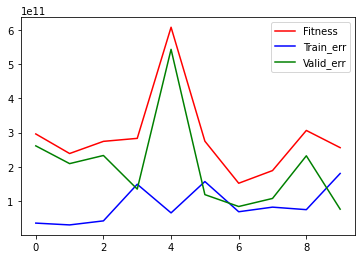

In [67]:
best_fit_gen = np.array(best_fit_gen, dtype = np.double)
best_train_err_gen = np.array(best_train_err_gen, dtype = np.double)
best_valid_err_gen = np.array(best_valid_err_gen, dtype = np.double)
print(best_fit_gen)
print(best_valid_err_gen)
print(best_train_err_gen)
plt.plot(best_fit_gen , color = "red")
plt.plot(best_train_err_gen, color ="blue" )
plt.plot(best_valid_err_gen , color = "green")
plt.legend(["Fitness", "Train_err", "Valid_err"])
plt.show()

In [7]:
import numpy as np
initial_array = [0.0, -1.45799022e-12, -2.28980078e-13,  4.62010753e-11, -1.75214813e-10, -1.83669770e-15,  8.52944060e-16,  2.29423303e-05, -2.04721003e-06, -1.59792834e-08,  9.98214034e-10]
check_arr =    [5.676391085132782e-10, -1.3857292723118332e-12, -2.2653919384209594e-13, 4.634432566014288e-11, -1.8256651150328223e-10, -1.8988854373633673e-15, 7.962947915504994e-16, 2.351580929846117e-05, -2.0282321098290316e-06, -1.56204124253323e-08, 9.43748938900726e-10]
initial_array = np.array(initial_array, dtype = np.double)
check_arr = np.array(check_arr , dtype = np.double)
max_val = initial_array + initial_array/10
max_val = np.clip(max_val,-10,+10)
min_val = initial_array - initial_array/10
min_val = np.clip(min_val,-10,+10)
max_val[0] = initial_array[0] + np.mean(initial_array)/1000
min_val[0] = initial_array[0] - np.mean(initial_array)/1000
for i in range(0,11):
    if ( check_arr[i] >max_val[i] or check_arr [i]<min_val[i]):
        print(i)

1
2
4
5
8
9


In [32]:
best_weights_set

[]

In [14]:
print("best values >>>>>>>>",name_file,datetime.datetime.now(),file=open("tt12.txt" , "a"))
print(fitness_best_weights,"\n", valid_err_best_weights,"\n", train_err_best_weights,"\n", best_weights_set,file=open("tt12.txt" , "a"))
print("=================================================================================\n\n\n\n",file=open("tt12.txt" , "a"))
